In [177]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [31]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score

def print_all_metrics(y_true, y_pred, binary=True, _round_=4):
    '''Print metrics'''
    print("Accuracy = {}, Balanced accuracy = {}".format(accuracy_score(y_true, y_pred).round(_round_),
                                                        balanced_accuracy_score(y_true, y_pred).round(_round_)))
    
    if binary:
        average_list = ['binary', 'micro', 'macro', 'weighted']
        print('In y_true, Pos = {}, Neg = {}, Pos/(Pos+Neg) = {}'.format(y_true[y_true == 1].count(), y_true[y_true == 0].count(),
                                                                   (y_true[y_true == 1].count() /  y_true[(y_true == 1) | (y_true == 0)].count()).round(_round_)))
    else:
        average_list = ['micro', 'macro', 'weighted', 'samples']
    metrics_list_of_dict = []
    for average in average_list:
        metrics_list_of_dict.append({'Average': average, 
                                     'Precision': precision_score(y_true, y_pred, average=average).round(_round_), 
                                     'Recall': recall_score(y_true, y_pred, average=average).round(_round_),
                                     'F1': f1_score(y_true, y_pred, average=average).round(_round_)})
        if average == 'binary':
            metrics_list_of_dict.append({'Average': average+"_pos_label=0", 
                                     'Precision': precision_score(y_true, y_pred, average=average, pos_label=0).round(_round_), 
                                     'Recall': recall_score(y_true, y_pred, average=average, pos_label=0).round(_round_),
                                     'F1': f1_score(y_true, y_pred, average=average, pos_label=0).round(_round_)})
    df_metrics = pd.DataFrame(metrics_list_of_dict)
    print(df_metrics)

In [23]:
titanic_data = pd.read_csv(r'data/titanic/train.csv')
X = titanic_data.drop(['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin'], axis=1)
X = pd.get_dummies(X)
X.Age.fillna(X.Age.median(), inplace=True)
y = titanic_data.Survived

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [24]:
parameters = {'n_estimators': [100], 
              'max_depth': range(3, 20, 1), 
              'min_samples_leaf': [1, 4, 8, 15, 30, 50],
              'min_samples_split': [2, 10, 20, 40, 100]}

In [27]:
grid_search_cf_clf = GridSearchCV(RandomForestClassifier(), parameters, 
                                  cv=5, n_jobs=-1, verbose=1, scoring='roc_auc') #n_jobs=-1 использовать все процессоры

In [28]:
grid_search_cf_clf.fit(X_train, y_train)

Fitting 5 folds for each of 510 candidates, totalling 2550 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(3, 20),
                         'min_samples_leaf': [1, 4, 8, 15, 30, 50],
                         'min_samples_split': [2, 10, 20, 40, 100],
                         'n_estimators': [100]},
             scoring='roc_auc', verbose=1)

In [29]:
grid_search_cf_clf.best_params_

{'max_depth': 15,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 100}

In [30]:
best_clf_rf = grid_search_cf_clf.best_estimator_

In [32]:
print_all_metrics(y_test, best_clf_rf.predict(X_test))

Accuracy = 0.8034, Balanced accuracy = 0.7832
In y_true, Pos = 120, Neg = 175, Pos/(Pos+Neg) = 0.4068
              Average  Precision  Recall      F1
0              binary     0.8100  0.6750  0.7364
1  binary_pos_label=0     0.8000  0.8914  0.8432
2               micro     0.8034  0.8034  0.8034
3               macro     0.8050  0.7832  0.7898
4            weighted     0.8041  0.8034  0.7998


In [33]:
roc_auc_score(y_test, best_clf_rf.predict_proba(X_test)[:, 1])

0.8843809523809525

<AxesSubplot:>

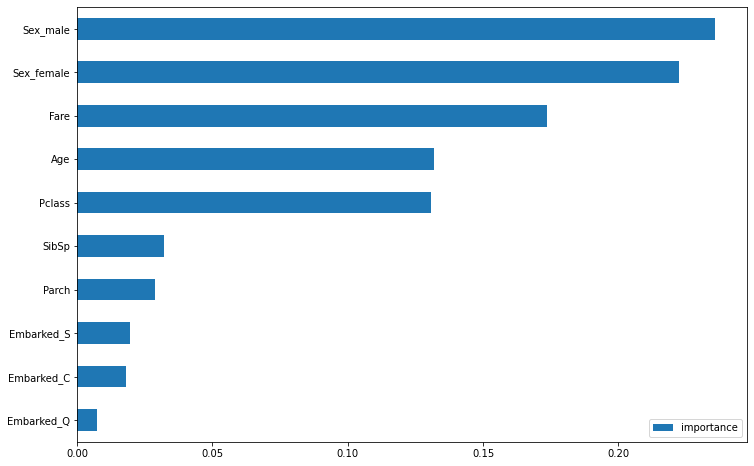

In [34]:
pd.DataFrame(best_clf_rf.feature_importances_, index=X_train.columns, columns=['importance'])\
    .sort_values('importance').plot(kind='barh', figsize=(12, 8))

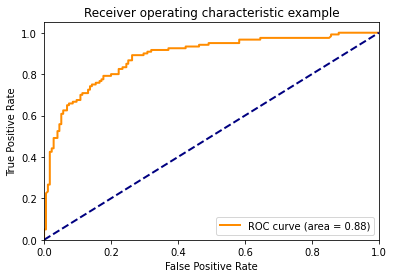

In [36]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, best_clf_rf.predict_proba(X_test)[:, 1])
roc_auc= auc(fpr, tpr)
lw = 2
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

**Пробую применить для решения задачи нейронную сеть**

In [178]:
import torch
import random
from sklearn.metrics import roc_auc_score

rs = 42
random.seed(rs)
np.random.seed(rs)
torch.manual_seed(rs)
torch.cuda.manual_seed(rs)
torch.backends.cudnn.deterministic = True

In [179]:
tsr_X_train = torch.FloatTensor(np.array(X_train))
tsr_X_test = torch.FloatTensor(np.array(X_test))
tsr_y_train = torch.LongTensor(np.array(y_train))
tsr_y_test = torch.LongTensor(np.array(y_test))

In [180]:
class StepNet(torch.nn.Module):
    def __init__(self, n_inputs, n_hidden_neurons):
        super(StepNet, self).__init__()
        self.fc1 = torch.nn.Linear(n_inputs, n_hidden_neurons)
        self.activ1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.activ2 = torch.nn.ReLU()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 1)
        self.activ3 = torch.nn.Sigmoid()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.activ1(x)
        x = self.fc2(x)
        x = self.activ2(x)
        x = self.fc3(x)
        x = self.activ3(x).reshape(-1)
        return x

    # def inference(self, x):
    #     x = self.forward(x)
    #     x = self.sm(x)
    #     return x
    
step_net = StepNet(tsr_X_train.shape[1], 5)

In [181]:
loss = torch.nn.BCELoss()

optimizer = torch.optim.Adam(step_net.parameters(), lr=1.0e-2)

In [182]:
learn_history = {}
learn_history['Epoch'] = []
learn_history['Accuracy_Test'] = []
learn_history['ROC_AUC_Test'] = []
learn_history['ROC_AUC_Train'] = []
learn_history['ROC_AUC_Diff'] = []

for epoch in range(2000):
    optimizer.zero_grad()
    preds = step_net.forward(tsr_X_train) 
        
    loss_value = loss(preds, tsr_y_train.float())
    loss_value.backward()
    
    optimizer.step()
    
    #Metrics
    test_preds = step_net.forward(tsr_X_test)
    train_preds = step_net.forward(tsr_X_train)
    learn_history['Epoch'].append(epoch+1)
    learn_history['Accuracy_Test'].append(float((tsr_y_test == (test_preds >= 0.5).int()).float().mean()))
    learn_history['ROC_AUC_Test'].append(roc_auc_score(np.array(tsr_y_test.data), np.array(test_preds.data)))
    learn_history['ROC_AUC_Train'].append(roc_auc_score(y_train, np.array(train_preds.data)))
    learn_history['ROC_AUC_Diff'].append(float(learn_history['ROC_AUC_Train'][-1] - learn_history['ROC_AUC_Test'][-1]))
    if epoch % 100 == 0:
        print("Epoch = {} - Accuracy_Test = {:.3f}, ROC_AUC: Test = {:.3f}, Train = {:.3f}, diff = {:.3f}".format(learn_history['Epoch'][-1], 
                                                                                          learn_history['Accuracy_Test'][-1],
                                                                                          learn_history['ROC_AUC_Test'][-1], 
                                                                                          learn_history['ROC_AUC_Train'][-1], 
                                                                                          learn_history['ROC_AUC_Diff'][-1]))

Epoch = 1 - Accuracy_Test = 0.644, ROC_AUC: Test = 0.744, Train = 0.654, diff = -0.090
Epoch = 101 - Accuracy_Test = 0.807, ROC_AUC: Test = 0.892, Train = 0.869, diff = -0.022
Epoch = 201 - Accuracy_Test = 0.800, ROC_AUC: Test = 0.877, Train = 0.866, diff = -0.011
Epoch = 301 - Accuracy_Test = 0.807, ROC_AUC: Test = 0.867, Train = 0.871, diff = 0.003
Epoch = 401 - Accuracy_Test = 0.820, ROC_AUC: Test = 0.862, Train = 0.875, diff = 0.012
Epoch = 501 - Accuracy_Test = 0.814, ROC_AUC: Test = 0.866, Train = 0.885, diff = 0.019
Epoch = 601 - Accuracy_Test = 0.810, ROC_AUC: Test = 0.863, Train = 0.885, diff = 0.022
Epoch = 701 - Accuracy_Test = 0.803, ROC_AUC: Test = 0.860, Train = 0.885, diff = 0.025
Epoch = 801 - Accuracy_Test = 0.810, ROC_AUC: Test = 0.859, Train = 0.886, diff = 0.027
Epoch = 901 - Accuracy_Test = 0.814, ROC_AUC: Test = 0.861, Train = 0.887, diff = 0.026
Epoch = 1001 - Accuracy_Test = 0.797, ROC_AUC: Test = 0.858, Train = 0.886, diff = 0.028
Epoch = 1101 - Accuracy_Test =

In [183]:
np.argmax(learn_history['ROC_AUC_Test']), max(learn_history['ROC_AUC_Test']), max(learn_history['Accuracy_Test'])

(97, 0.8926190476190476, 0.8271186351776123)

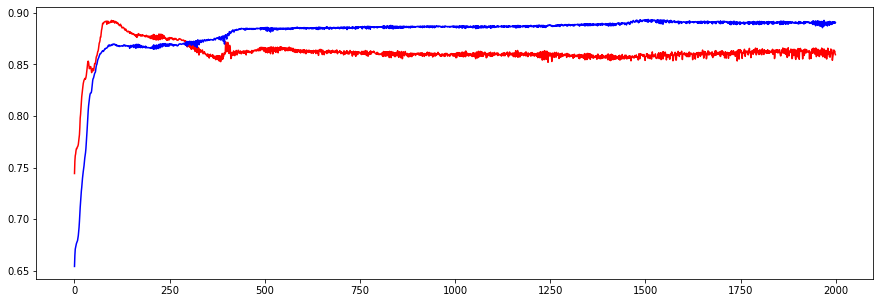

In [184]:
matplotlib.rcParams['figure.figsize'] = (15.0, 5.0)
plt.plot(learn_history['ROC_AUC_Test'], c='r')
plt.plot(learn_history['ROC_AUC_Train'], c='b')